In [16]:
import glob

import matplotlib.pyplot as plt
import scipy.stats as sts
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.weightstats import _tconfint_generic
import glob

### В этом блоке проверяем гипотезу о том, что по утрам наблюдается всплеск в спреде. 

Начнем с того что просто посмотрим на то как выглядят спреды разных бирж в зависимости от времени.
Можно легко заметить что в начале дня в промежутке между 6 и 7 утра визуально наблюдается всплеск в спредах.
По всей видимости именно он и является причиной поставленного эксперимента.

Index(['Time_utc', 'BidAskSpread_bp', 'MidPrice_Open', 'MidPrice_High',
       'MidPrice_Low', 'MidPrice_Close', 'name'],
      dtype='object')


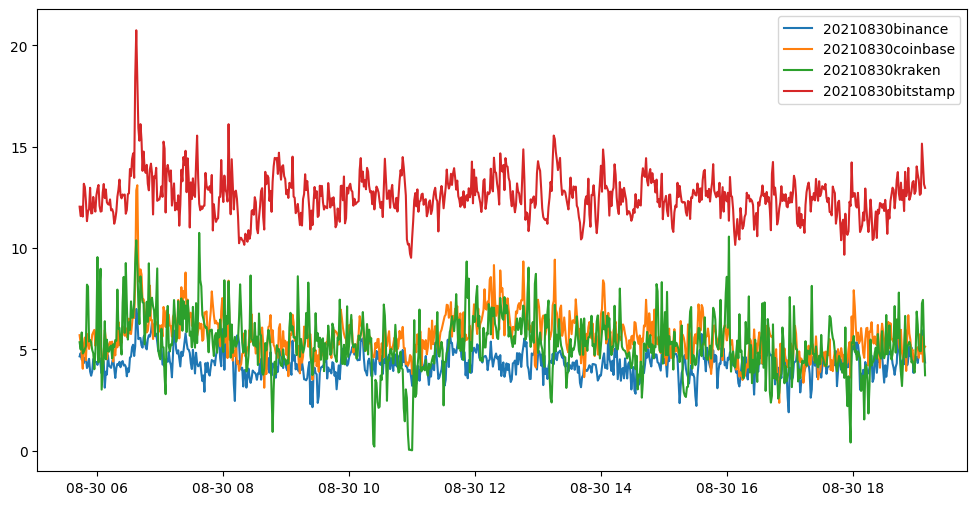

In [13]:
data = [pd.read_csv(_path) for _path in glob.glob("crypto_data/*.csv")]
for i, name in enumerate(
    [_path.split("/")[-1].split(".")[0] for _path in glob.glob("crypto_data/*.csv")]
):
    data[i]["name"] = name
    data[i]["Time_utc"] = pd.to_datetime(data[i]["Time_utc"])

print(data[0].columns)
plt.figure(figsize=(12, 6))
for _ in data:
    plt.plot(_["Time_utc"], _["BidAskSpread_bp"], label=_["name"].iloc[0])
plt.legend(loc="upper right")
plt.show()

Также мы знаем что среднее значение спреда является положительным, а значит мы должны иметь распределение со средним находящимся справа от нуля. Также следует отметить что невозможна ситуация при которой дельта в спреде меньше 0, а значит мы работаем с распределением ограниченным нулем слева. Интерес представляет посмотреть на форму распределений у спредов в течение дня для различных бирж. Для того чтобы визуализировать распределения стоит построить гистограммы.

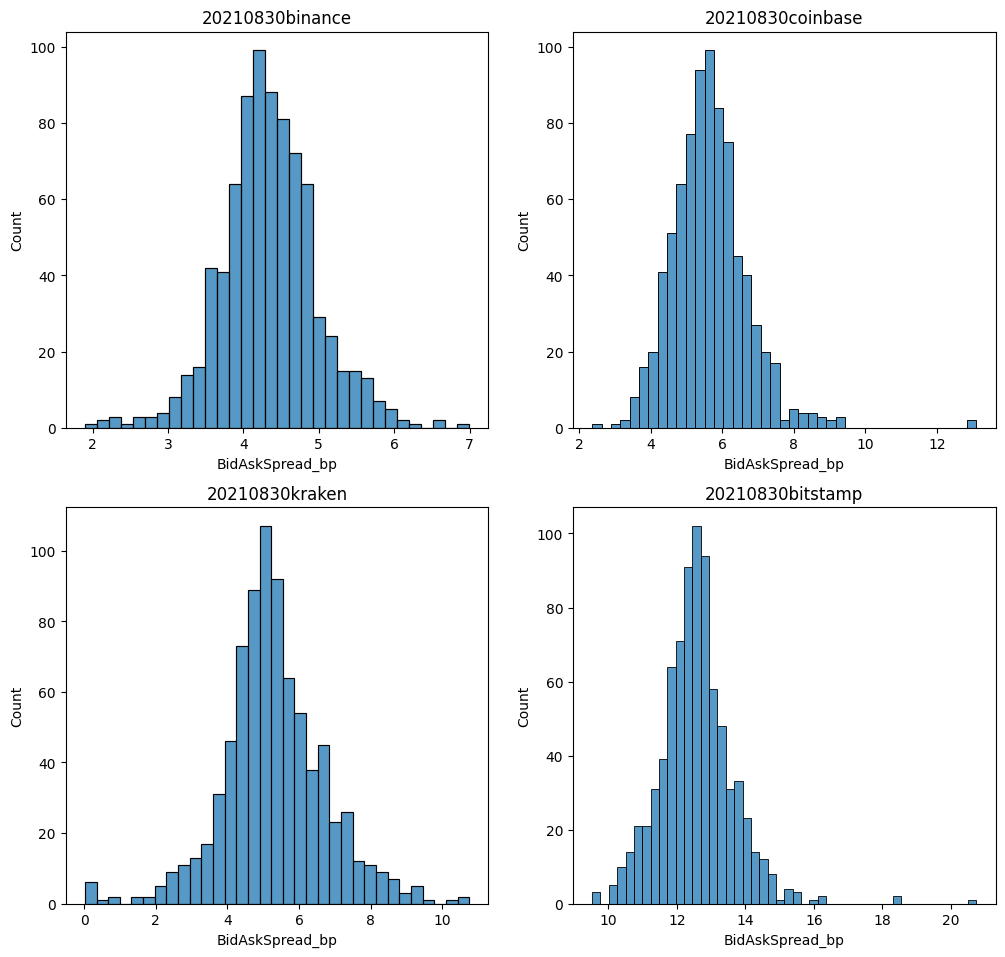

In [48]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
fig.subplots_adjust(left=None, bottom=None, right=None, top=1.2, wspace=None, hspace=None)
for i, _ in enumerate(data):
    ax[i // 2, i % 2].set_title(f"{_['name'].iloc[0]}")
    sns.histplot(_["BidAskSpread_bp"], ax=ax[i // 2, i % 2])
plt.show()

Так как видно, что средние значения спредов отличаются для каждого из рынков, весьма логичным действием является осуществление первичной предобработки данных. Для этого воспользуемся стандартным обработчиком из sklearn. Разумеется, что профили останутся прежними, но теперь мы имеем одинаковое среднее, что позволит с большим удобством сравнивать гистограммы. 

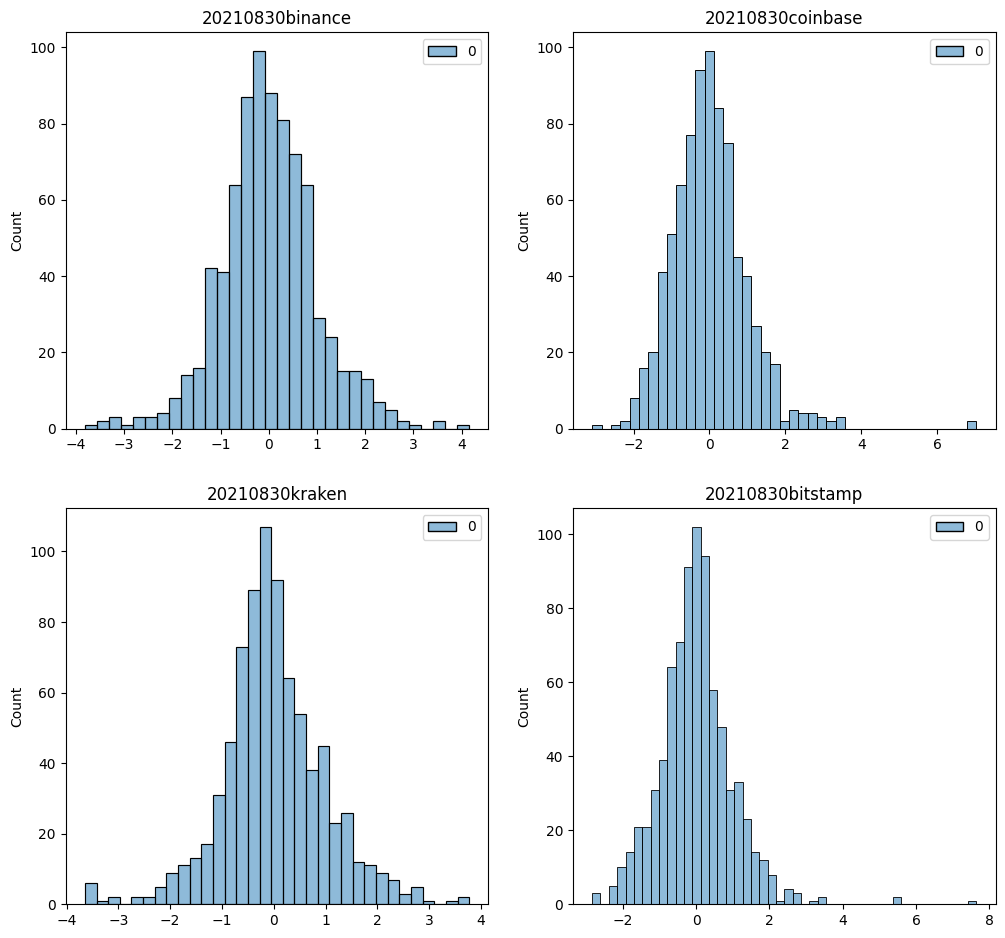

In [50]:
scaler = StandardScaler()
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
fig.subplots_adjust(left=None, bottom=None, right=None, top=1.2, wspace=None, hspace=None)
for i, _ in enumerate(data):
    ax[i // 2, i % 2].set_title(f"{_['name'].iloc[0]}")
    sns.histplot(scaler.fit_transform(_["BidAskSpread_bp"].values.reshape(-1,1)), ax=ax[i // 2, i % 2])
plt.show()

Построим аналог BBands, где в качестве верхнего и нижнего уровня будут выступать границы доверительных интервалов. 
Таким образом нам удастся посмотреть на динамику изменения доверительных интервалов на всем временном промежутке.

Тут важно заметить что мы не знаем теоретическую дисперсию $\sigma_{C, B, ...}}$, поэтому корректней будет использовать t-интервал (использование выборочных дисперсий). Для такого случая доверительные интервалы примут вид


$$\hat{X_t} \pm t_{1 - \frac{\alpha}{2}}\frac{S}{\sqrt{n}}$$.

Чтобы самому это не писать, используем statsmodels

In [83]:
def create_bb_analog(observations: pd.Series, window_size_sec: int = 10, alpha=0.05):
    def apply_interval_to_window(ser: pd.Series):
        mean_value = ser.mean()
        std_value = ser.std(ddof=1) / np.sqrt(len(ser))
        left, right = _tconfint_generic(
            mean_value, std_value, len(ser) - 1, alpha, "two-sided"
        )
        return mean_value, left, right

    intervals = pd.DataFrame(
        [
            apply_interval_to_window(window)
            for window in observations.rolling(f"{window_size_sec}s")
        ]
    )
    intervals.columns = ["mean_value", "interval_left", "interval_right"]
    intervals.index = observations.index
    return pd.concat([observations, intervals], axis=1)
# test_NUM = 40
# test_series = pd.Series(
#     [1] * test_NUM,
#     index=[
#         pd.Timestamp(f'20130101 09:00:{_ if _ >=10 else f"0{_}"}')
#         for _ in range(test_NUM)
#     ],
# )
# create_bb_analog(observations=test_series, window_size_sec=3)

,0,mean_value,interval_left,interval_right
2013-01-01 09:00:00,1,1.0,NaN,NaN
2013-01-01 09:00:01,1,1.0,1.0,1.0
2013-01-01 09:00:02,1,1.0,1.0,1.0
2013-01-01 09:00:03,1,1.0,1.0,1.0
2013-01-01 09:00:04,1,1.0,1.0,1.0
2013-01-01 09:00:05,1,1.0,1.0,1.0
2013-01-01 09:00:06,1,1.0,1.0,1.0
2013-01-01 09:00:07,1,1.0,1.0,1.0
2013-01-01 09:00:08,1,1.0,1.0,1.0
2013-01-01 09:00:09,1,1.0,1.0,1.0


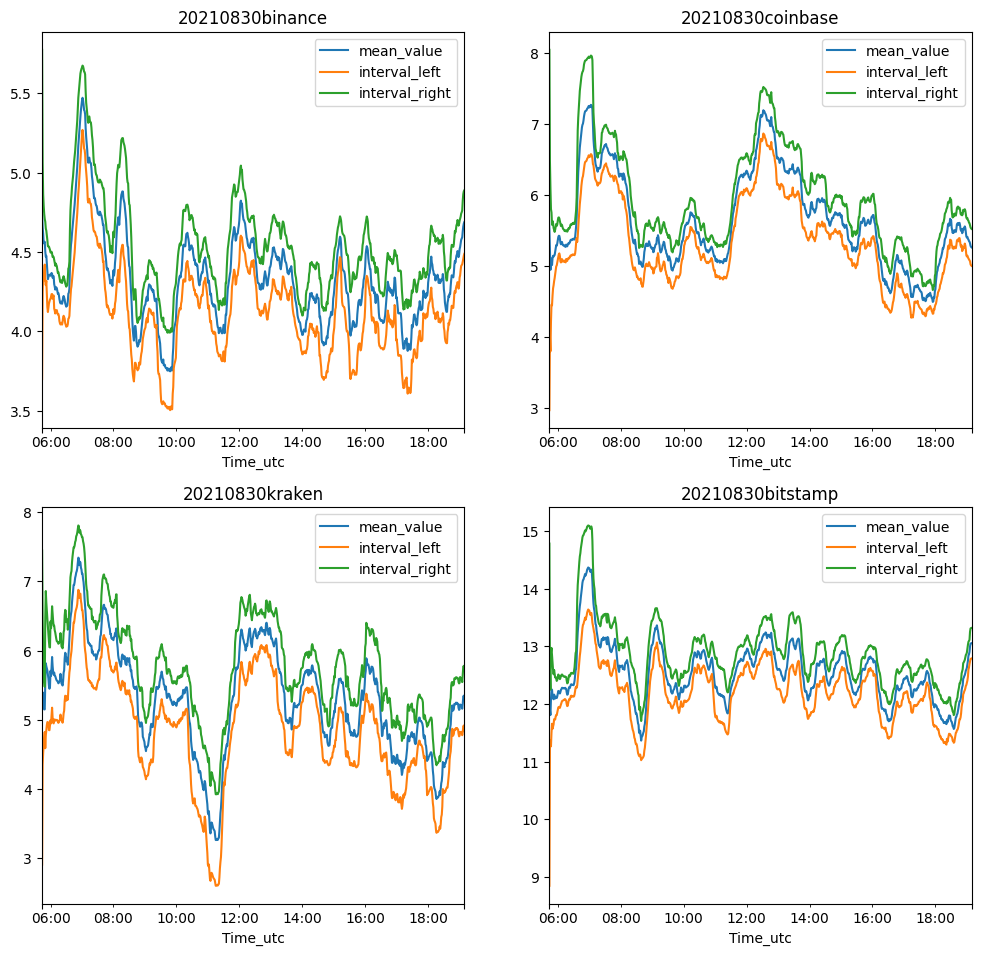

In [105]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
fig.subplots_adjust(left=None, bottom=None, right=None, top=1.2, wspace=None, hspace=None)

window_minutes_size = 30    # 0.5 Hour
for i, _ in enumerate(data):
    ax[i // 2, i % 2].set_title(f"{_['name'].iloc[0]}")
    _tmp = _.copy()
    _tmp.index = _tmp['Time_utc']
    _tmp = _tmp["BidAskSpread_bp"]
    create_bb_analog(_tmp, window_size_sec=60 * window_minutes_size).drop("BidAskSpread_bp", axis=1).plot(ax=ax[i // 2, i % 2])
plt.show()

Получившиеся результаты говорят о том, что нельзя принять нашу гипотезу для каждого рынка. Однако следует отметить, что в случае binance действительно имеется значимое различие среднего в спреде в точках соответствующих 7:00 и остальными после 8:00.

Также следует учитывать что всплески спредов могут быть связанны с переключением торговых сессий (особенность торговли 24/7) 
Азиатская -> Европейская -> Американская. Подобные исследования требуют большее количество исторических данных.

Также в качестве "бонуса" я хотел бы добавить классический метод для доверительных интервалов, на случай если ожидался он

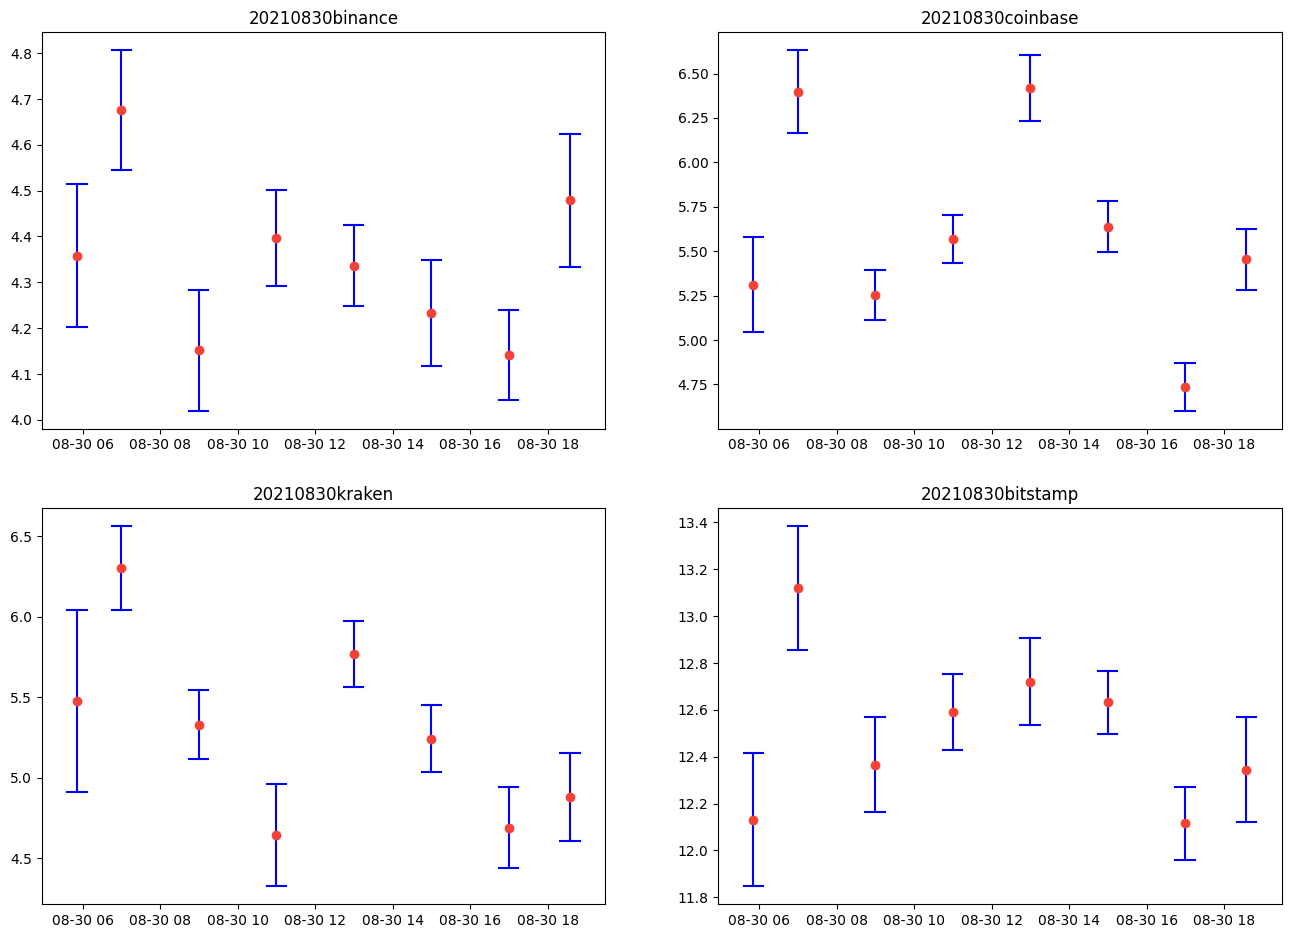

In [179]:
def conservative_confidence(observations: pd.Series, window_size_sec: int = 10, alpha=0.05):
    def apply_interval_to_window(tupled_ser: pd.Series):
        ser = tupled_ser[1]
        mean_time = ser.index.mean()
        mean_value = ser.mean()
        std_value = ser.std(ddof=1) / np.sqrt(len(ser))
        left, right = _tconfint_generic(
            mean_value, std_value, len(ser) - 1, alpha, "two-sided"
        )
        return mean_time, mean_value, left, right

    intervals = pd.DataFrame(
        [
            apply_interval_to_window(window)
            for window in observations.resample(f"{window_size_sec}s")
        ]
    )
    intervals.columns = ["mean_time", "mean_value", "interval_left", "interval_right"]
    intervals.set_index("mean_time", drop=True, inplace=True)
    intervals.index = pd.to_datetime(intervals.index)
    return intervals

def plot_confidence(confidence_series: pd.Series, x, ax, horizontal_line_width=60 * 15, color='blue'):
    left = x - pd.Timedelta(seconds=horizontal_line_width)
    top = confidence_series[["interval_right"]].values[0]
    right = x + pd.Timedelta(seconds=horizontal_line_width)
    bottom = confidence_series[["interval_left"]].values[0]
    ax.plot([x, x], [top, bottom], color=color)
    ax.plot([left, right], [top, top], color=color)
    ax.plot([left, right], [bottom, bottom], color=color)
    ax.plot(x, confidence_series[["mean_value"]].values[0], 'o', color='#f44336')
    
fig, ax = plt.subplots(2, 2, figsize=(16, 8))
fig.subplots_adjust(left=None, bottom=None, right=None, top=1.2, wspace=None, hspace=None)

window_minutes_size = 120    # 2 Hour
for i, _ in enumerate(data):
    ax[i // 2, i % 2].set_title(f"{_['name'].iloc[0]}")
    _tmp = _.copy()
    _tmp.index = _tmp['Time_utc']
    _tmp = _tmp["BidAskSpread_bp"]
    _tmp = conservative_confidence(_tmp, window_size_sec=60 * window_minutes_size)
    for arrow in range(_tmp.shape[0]):
        plot_confidence(confidence_series=_tmp.iloc[arrow], x=_tmp.index[arrow], ax=ax[i // 2, i % 2])
    # conservative_confidence(_tmp, window_size_sec=60 * window_minutes_size).plot(ax=ax[i // 2, i % 2])
plt.show()

## Проверка на нормальность распределения разницы между максимальными и минимальными ценами

Сначала построим гистограммы

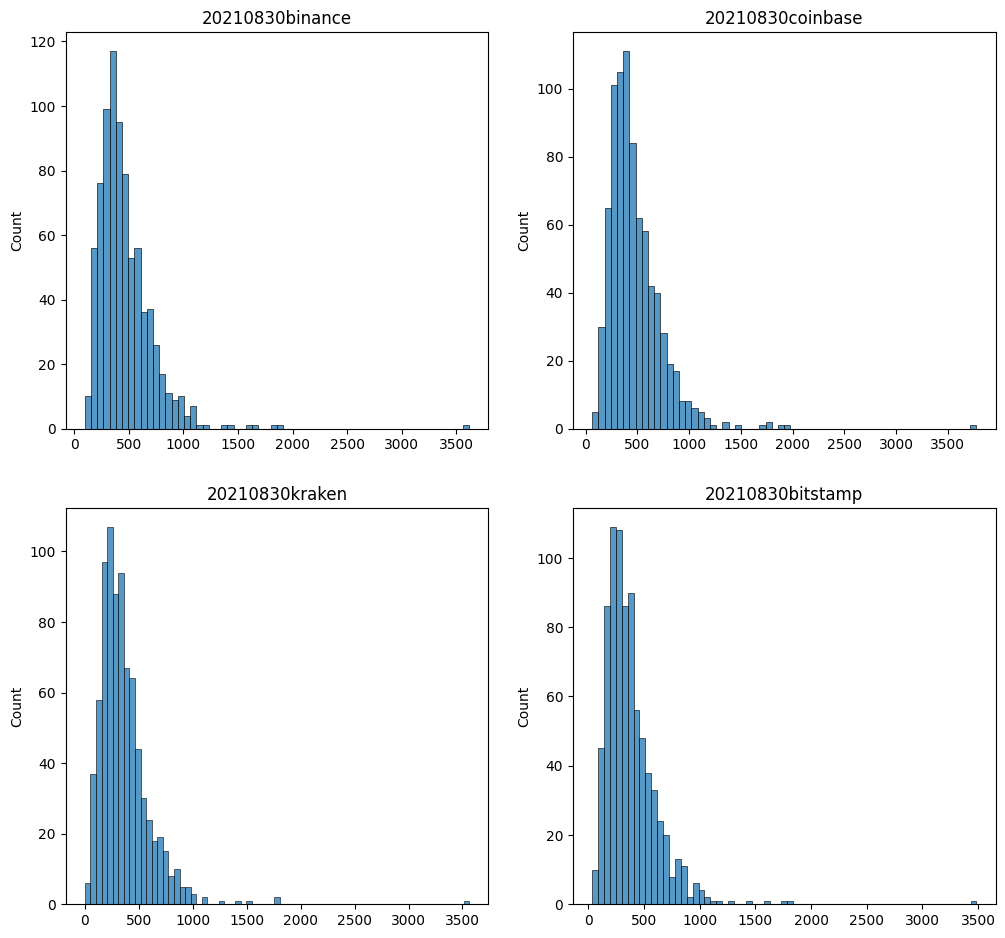

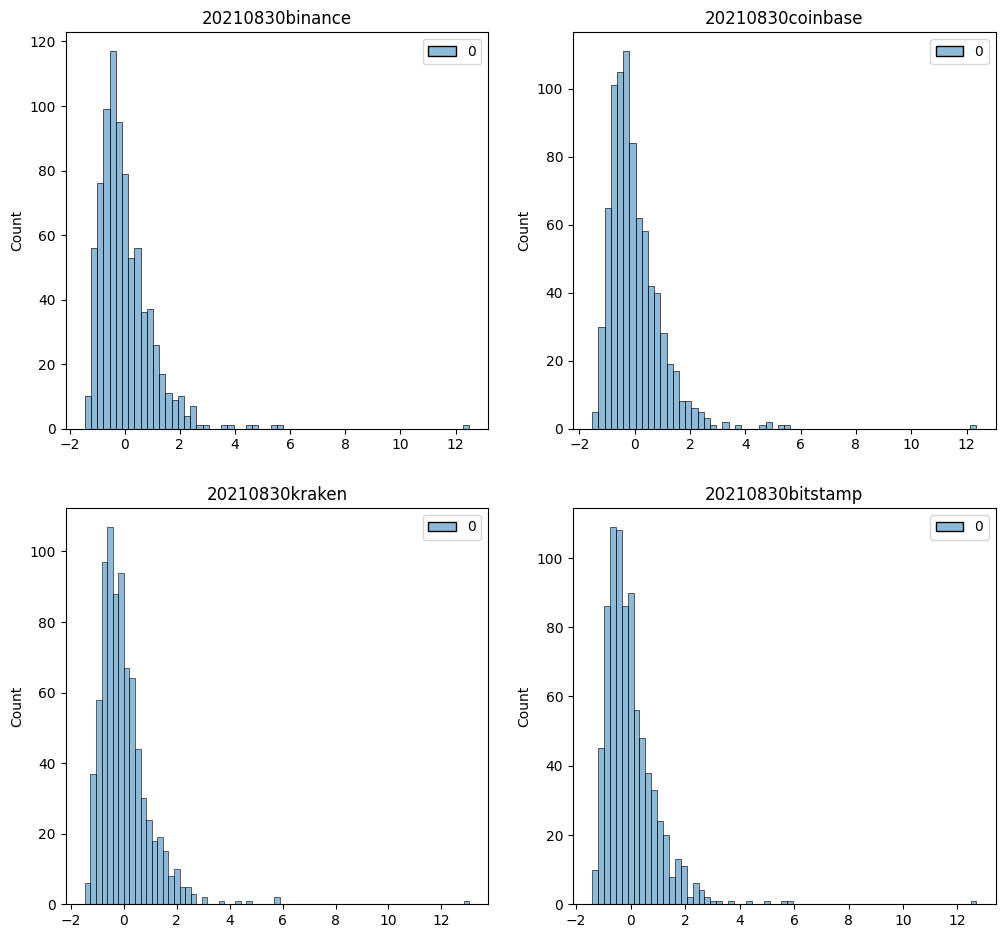

In [189]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
fig.subplots_adjust(left=None, bottom=None, right=None, top=1.2, wspace=None, hspace=None)
for i, _ in enumerate(data):
    ax[i // 2, i % 2].set_title(f"{_['name'].iloc[0]}")
    sns.histplot((_["MidPrice_High"] - _['MidPrice_Low']), ax=ax[i // 2, i % 2])
plt.show()
# 
scaler = StandardScaler()
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
fig.subplots_adjust(left=None, bottom=None, right=None, top=1.2, wspace=None, hspace=None)
for i, _ in enumerate(data):
    ax[i // 2, i % 2].set_title(f"{_['name'].iloc[0]}")
    sns.histplot(scaler.fit_transform((_["MidPrice_High"] - _['MidPrice_Low']).values.reshape(-1,1)), ax=ax[i // 2, i % 2])
plt.show()

Сразу следует отметить, что распределение разницы является ограниченным нулем слева. Можно переформулировать задачу как проверка на то что разница соответствует логнормальному распределению, однако гораздо проще будет просто взять логарифм. 

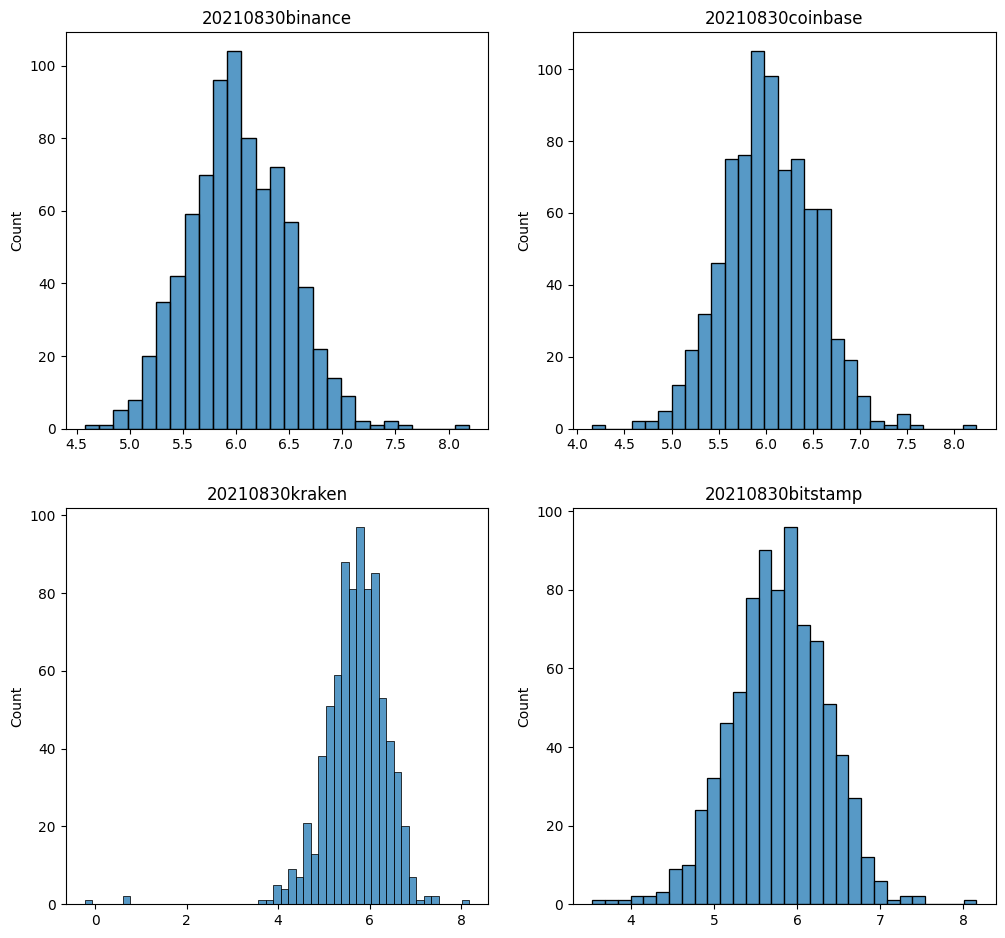

In [221]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
fig.subplots_adjust(left=None, bottom=None, right=None, top=1.2, wspace=None, hspace=None)
for i, _ in enumerate(data):
    ax[i // 2, i % 2].set_title(f"{_['name'].iloc[0]}")
    __ = _["MidPrice_High"] - _['MidPrice_Low']
    __ = __[__ != 0]
    sns.histplot(np.log(__), ax=ax[i // 2, i % 2])
plt.show()

Типичными критериями для проверки нормальности распределения являются:

1. QQ-plot
2. Критерий Шапиро-Уилка
3. Критерий Д’Агостино


/Users/rualpam/Projects/MiptStatsMethods/env/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


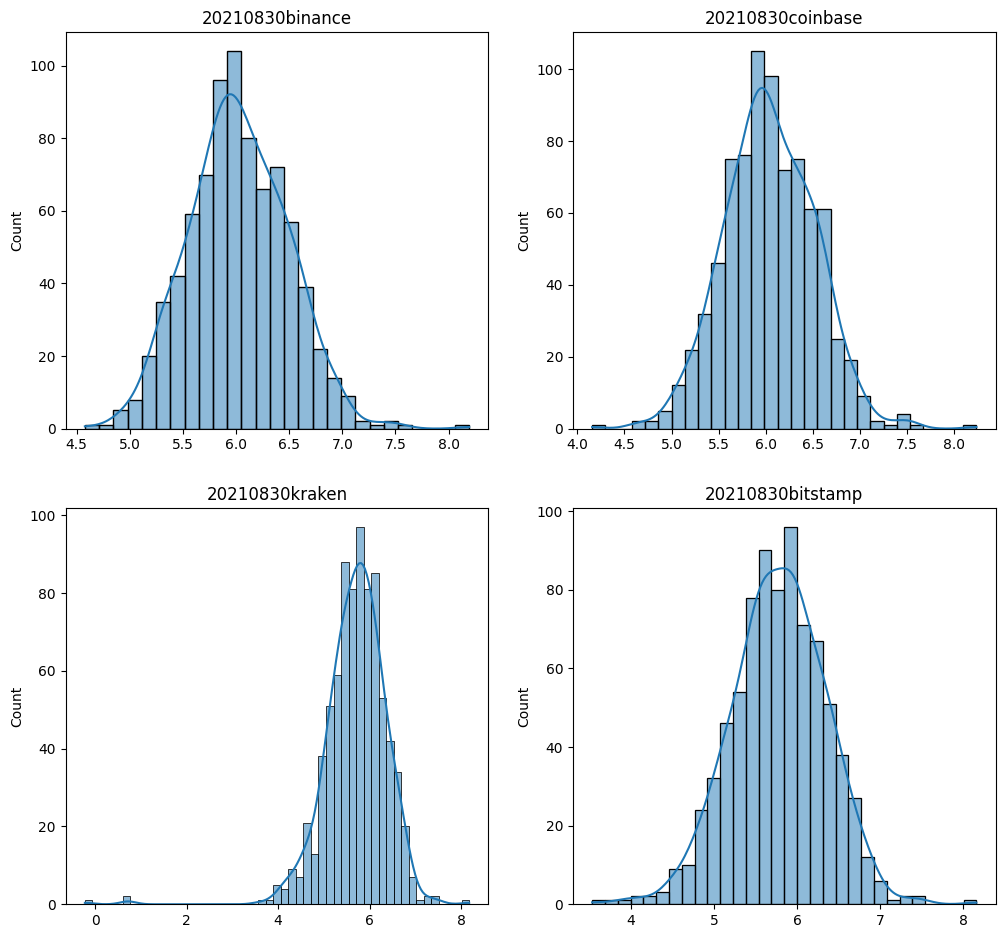

In [195]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
fig.subplots_adjust(left=None, bottom=None, right=None, top=1.2, wspace=None, hspace=None)
for i, _ in enumerate(data):
    ax[i // 2, i % 2].set_title(f"{_['name'].iloc[0]}")
    sns.histplot(np.log(_["MidPrice_High"] - _['MidPrice_Low']), ax=ax[i // 2, i % 2], kde=True)
plt.show()

QQ plots.

Главный вывод который можно сделать - то что мы имеем дело с распределением с тяжелыми хвостами.
Было бы очень наивно в случае например оценки рисков принять предположение о том что данные распределены нормально.

Дополнительно хотелось бы построить аналогичные графики для логарифмов возвратов. Для них можно заметить что тяжелые хвосты выражены более явно, что является ожидаемым поведением, так как мы работаем с финансовыми данными.

/Users/rualpam/Projects/MiptStatsMethods/env/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/rualpam/Projects/MiptStatsMethods/env/lib/python3.10/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


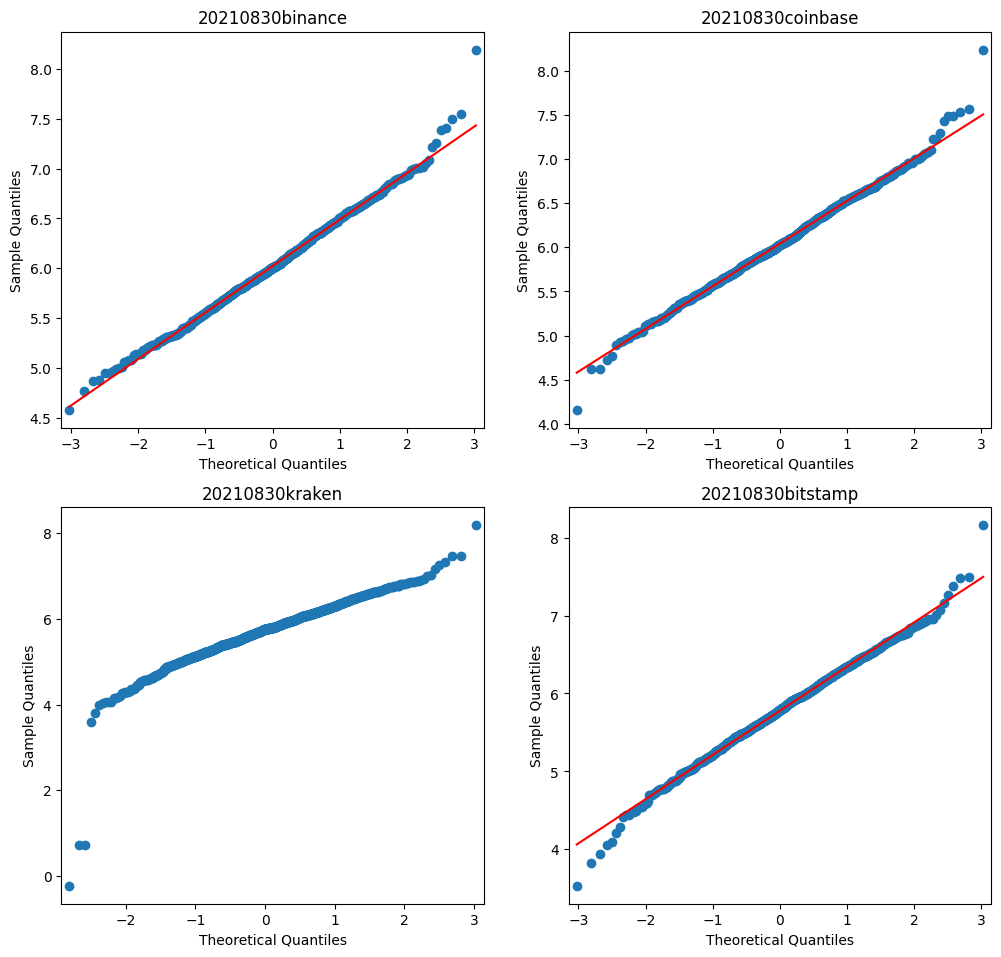

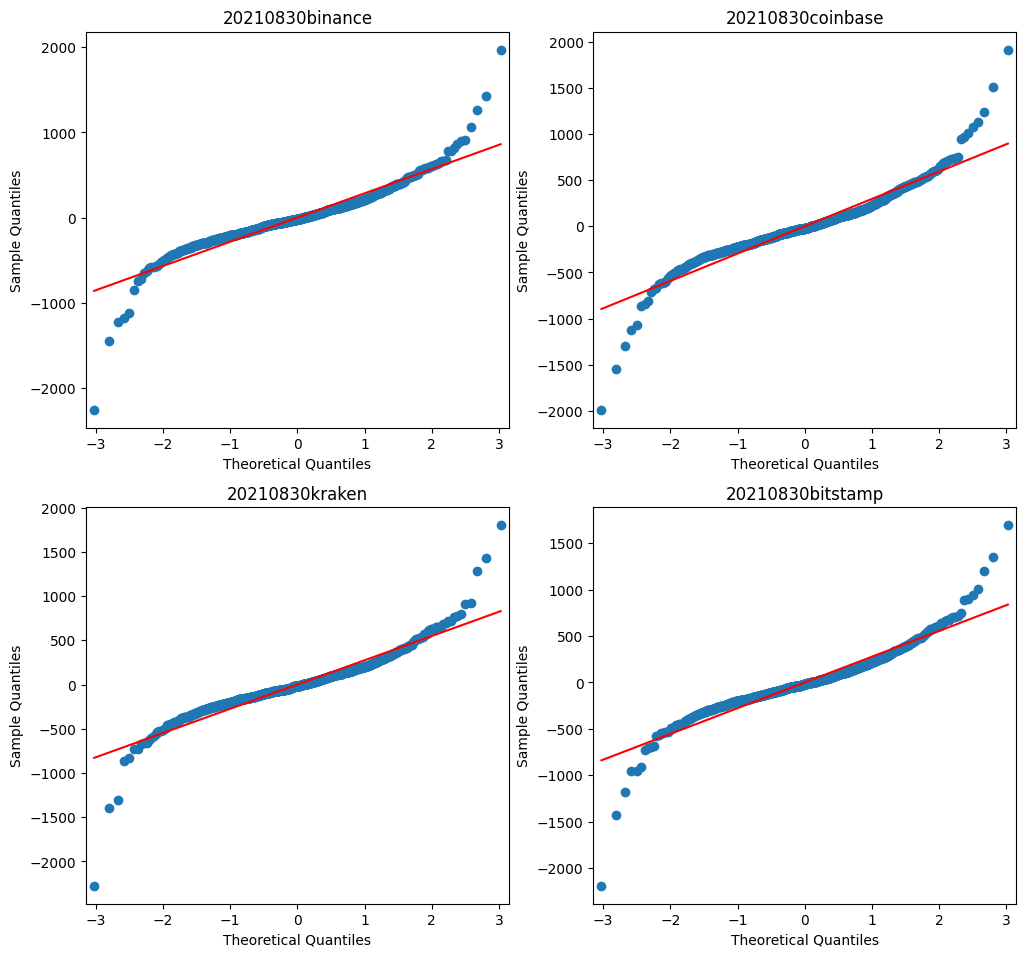

In [198]:
from statsmodels.graphics.gofplots import qqplot
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
fig.subplots_adjust(left=None, bottom=None, right=None, top=1.2, wspace=None, hspace=None)
for i, _ in enumerate(data):
    ax[i // 2, i % 2].set_title(f"{_['name'].iloc[0]}")
    qqplot(np.log(_["MidPrice_High"] - _['MidPrice_Low']), ax=ax[i // 2, i % 2], line='s')
plt.show()

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
fig.subplots_adjust(left=None, bottom=None, right=None, top=1.2, wspace=None, hspace=None)
for i, _ in enumerate(data):
    ax[i // 2, i % 2].set_title(f"{_['name'].iloc[0]}")
    qqplot(np.diff(_["MidPrice_High"] - _['MidPrice_Low']), ax=ax[i // 2, i % 2], line='s')
plt.show()

Теперь проведем более формальное (не визуальное) тестирование. Для этого воспользуемся критериями
1. Критерий Шапиро-Уилка
2. Критерий Д’Агостино

Очень удобно что они любезно представлены в библиотеке scipy.

Важно отметить что по какой-то причине на бирже Kraken присутствует ошибка в данных (совпадение минимальной и максимальной цены).
В реальном мире такая ситуация насколько мне известно - невозможна.

Мной было решено убрать такие строчки


In [233]:
print("Is any zeros before np.log:", np.any((data[2]["MidPrice_High"] - data[2]['MidPrice_Low']) == 0))

Is any zeros before np.log: True


In [244]:
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import kstest
from scipy.stats import norm as normal_distribution

specified_p_value = 0.05
for i, _ in enumerate(data):
    _naming = f"{_['name'].iloc[0]}"
    logs = _["MidPrice_High"] - _['MidPrice_Low']
    logs = logs[logs != 0]
    logs = np.log(logs)
    print("=======" * 8, f"   {_naming}   ", "=======" * 8)
    print(f"Shapiro: {shapiro(logs)}", f"Not normal for {specified_p_value=} is: {shapiro(logs)[1] < specified_p_value}")
    print(f"Agostino: {normaltest(logs)}", f"Not normal for {specified_p_value=} is: {normaltest(logs)[1] < specified_p_value}")
    print(f"Kolmogorov: {kstest(logs, normal_distribution.cdf)}", f"Not normal for {specified_p_value=} is: {kstest(logs, normal_distribution.cdf)[1] < specified_p_value}")
    print("\n")

========================================================    20210830binance    ========================================================
Shapiro: ShapiroResult(statistic=0.9957578778266907, pvalue=0.026396729052066803) Not normal for specified_p_value=0.05 is: True
Agostino: NormaltestResult(statistic=8.805035725009699, pvalue=0.012246466133531255) Not normal for specified_p_value=0.05 is: True
Kolmogorov: KstestResult(statistic=0.9999976377963841, pvalue=0.0, statistic_location=4.576667825515403, statistic_sign=-1) Not normal for specified_p_value=0.05 is: True


========================================================    20210830coinbase    ========================================================
Shapiro: ShapiroResult(statistic=0.9958845376968384, pvalue=0.03128862753510475) Not normal for specified_p_value=0.05 is: True
Agostino: NormaltestResult(statistic=9.270511960590673, pvalue=0.009703622784176977) Not normal for specified_p_value=0.05 is: True
Kolmogorov: KstestResult(statisti

### Итог: все тесты с p_value в 0.05 показали что представленные данные не принадлежат нормальному распределению